In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
# from imblearn.over_sampling import SMOTE, RandomOverSampler

df= pd.read_csv('bank-additional-full.csv', sep=';', encoding='utf-8')
# Results for all clients
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
#Categorising ages into bins
# bins = [0,20,40,60,80,100]
# labels = ['0-20','21-40','41-60','61-80','81-100']
# df['age_bin']=pd.cut(df['age'], bins=bins, labels=labels)

#Set max values 
df['campaign']=df['campaign'].apply(lambda x: max(4, x))

#Applying one hot encoding to categorical columns
df=pd.get_dummies(df, columns=['job'], dtype=int)
df= pd.get_dummies(df, columns=['marital'], dtype=int)
df= pd.get_dummies(df, columns=['education'], dtype=int)
df= pd.get_dummies(df, columns=['default'], dtype=int)
df= pd.get_dummies(df, columns=['housing'], dtype=int)
df= pd.get_dummies(df, columns=['loan'], dtype=int)
df= pd.get_dummies(df, columns=['contact'], dtype=int)
df= pd.get_dummies(df, columns=['month'], dtype=int)
df= pd.get_dummies(df, columns=['day_of_week'], dtype=int)
df= pd.get_dummies(df, columns=['poutcome'], dtype=int)

#Replacing negative values to zero
df['emp.var.rate']=df['emp.var.rate'].apply(lambda x: max(0, x))
df['cons.conf.idx']=df['cons.conf.idx'].apply(lambda x: max(0, x))

#One hot encoding of 'y' column
df['y']=df['y'].replace({'yes':1,'no':0})

#Dropping column
df = df.drop('duration', axis=1)

#Replacing values
df['pdays']=df['pdays'].replace({999:0})

#Rearranging columns
cols = list(df.columns)
cols.remove('y')           
cols.insert(cols.index('poutcome_success') + 1, 'y')  

# Reorder dataframe
df = df[cols]

/var/folders/3t/kqzykkfx49d7ljggm3b2fc3m0000gn/T/ipykernel_5275/1929695882.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y']=df['y'].replace({'yes':1,'no':0})


In [3]:
df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,56,4,0,0,1.1,93.994,0,4.857,5191.0,0,...,0,0,1,0,0,0,0,1,0,0
1,57,4,0,0,1.1,93.994,0,4.857,5191.0,0,...,0,0,1,0,0,0,0,1,0,0
2,37,4,0,0,1.1,93.994,0,4.857,5191.0,0,...,0,0,1,0,0,0,0,1,0,0
3,40,4,0,0,1.1,93.994,0,4.857,5191.0,1,...,0,0,1,0,0,0,0,1,0,0
4,56,4,0,0,1.1,93.994,0,4.857,5191.0,0,...,0,0,1,0,0,0,0,1,0,0


In [4]:
#Define x and y
# x=df.iloc[:,0:62]
# y=df.iloc[:,-1]

#Select top 3 features
# best_features=SelectKBest(score_func=chi2,k=3)
# fit=best_features.fit(x,y)

#Create data frames for the features and the score of each feature
# df_scores=pd.DataFrame(fit.scores_)
# df_columns=pd.DataFrame(x.columns)

#Combine all the features and their correspionding scores in one data frame
# features_scores=pd.concat([df_columns,df_scores], axis=1)
# features_scores.columns=['Features','Score']
# features_scores.sort_values(by='Score').tail(50)

In [5]:
x= df.drop(['y'], axis=1)  # Features
y= df['y']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


In [6]:
logregmodel=LogisticRegression()
logregmodel.fit(x_train,y_train)

y_pred_logreg=logregmodel.predict(x_test)
print(x_test)
print(y_pred_logreg)

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


       age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
32884   57         4      0         1           0.0          92.893   
3169    55         4      0         0           1.1          93.994   
32206   33         4      0         1           0.0          92.893   
9403    36         4      0         0           1.4          94.465   
14020   27         4      0         0           1.4          93.918   
...    ...       ...    ...       ...           ...             ...   
12322   27         4      0         0           1.4          93.918   
23440   41         7      0         0           1.4          93.444   
29431   46        12      0         1           0.0          93.075   
16627   31         4      0         0           1.4          93.918   
1871    59         4      0         0           1.1          93.994   

       cons.conf.idx  euribor3m  nr.employed  job_admin.  ...  month_oct  \
32884              0      1.299       5099.1           0  ...          

In [7]:
print('Logistic Regression:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_logreg))
print('Recall: ',metrics.recall_score(y_test, y_pred_logreg, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_logreg, zero_division=1))
print('CL Report: ',metrics.classification_report(y_test, y_pred_logreg, zero_division=1))
accuracy_log=metrics.accuracy_score(y_test, y_pred_logreg)
accuracy_log

Logistic Regression:
Accuracy:  0.8964554503520272
Recall:  0.1925133689839572
Precision:  0.6474820143884892
CL Report:                precision    recall  f1-score   support

           0       0.91      0.99      0.94      7303
           1       0.65      0.19      0.30       935

    accuracy                           0.90      8238
   macro avg       0.78      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



0.8964554503520272

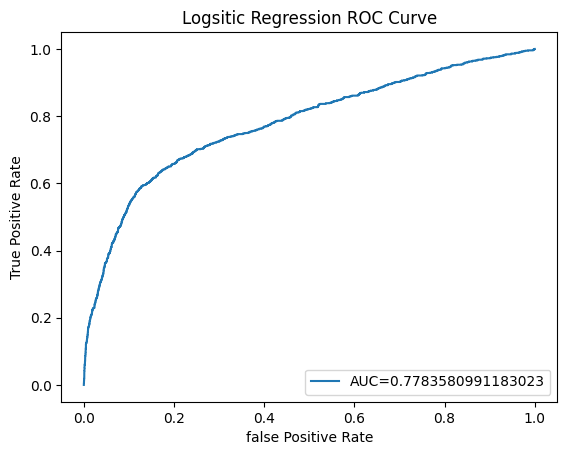

In [8]:
y_pred_proba= logregmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Logsitic Regression ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [ ]:
rfcmodel = RandomForestClassifier()
rfcmodel.fit(x_train, y_train)

y_pred_rfc=rfcmodel.predict(x_test)
print(x_test)
print(y_pred_rfc)

       age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
32884   57         4      0         1           0.0          92.893   
3169    55         4      0         0           1.1          93.994   
32206   33         4      0         1           0.0          92.893   
9403    36         4      0         0           1.4          94.465   
14020   27         4      0         0           1.4          93.918   
...    ...       ...    ...       ...           ...             ...   
12322   27         4      0         0           1.4          93.918   
23440   41         7      0         0           1.4          93.444   
29431   46        12      0         1           0.0          93.075   
16627   31         4      0         0           1.4          93.918   
1871    59         4      0         0           1.1          93.994   

       cons.conf.idx  euribor3m  nr.employed  job_admin.  ...  month_oct  \
32884              0      1.299       5099.1           0  ...          

In [10]:
print('Random Forest Classifier:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_rfc))
print('Recall: ',metrics.recall_score(y_test, y_pred_rfc, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_rfc, zero_division=1))
print('CL Report: ',metrics.classification_report(y_test, y_pred_rfc, zero_division=1))
accuracy_rfc=metrics.accuracy_score(y_test, y_pred_rfc)
accuracy_rfc

Random Forest Classifier:
Accuracy:  0.8868657441126487
Recall:  0.2877005347593583
Precision:  0.502803738317757
CL Report:                precision    recall  f1-score   support

           0       0.91      0.96      0.94      7303
           1       0.50      0.29      0.37       935

    accuracy                           0.89      8238
   macro avg       0.71      0.63      0.65      8238
weighted avg       0.87      0.89      0.87      8238



0.8868657441126487

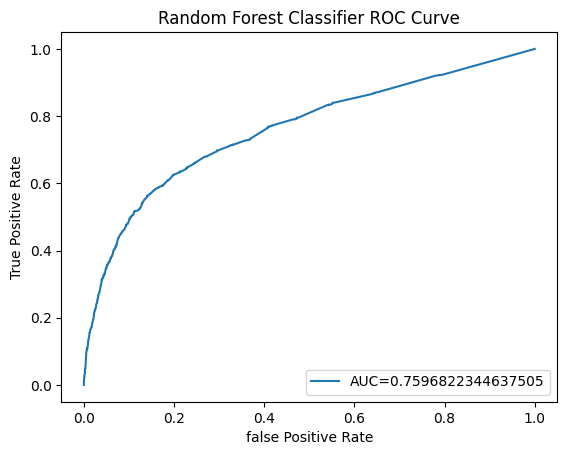

In [11]:
y_pred_proba= rfcmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Random Forest Classifier ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [12]:
dtcmodel = DecisionTreeClassifier()
dtcmodel.fit(x_train, y_train)

y_pred_dtc=dtcmodel.predict(x_test)
print(x_test)
print(y_pred_dtc)

       age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
32884   57         4      0         1           0.0          92.893   
3169    55         4      0         0           1.1          93.994   
32206   33         4      0         1           0.0          92.893   
9403    36         4      0         0           1.4          94.465   
14020   27         4      0         0           1.4          93.918   
...    ...       ...    ...       ...           ...             ...   
12322   27         4      0         0           1.4          93.918   
23440   41         7      0         0           1.4          93.444   
29431   46        12      0         1           0.0          93.075   
16627   31         4      0         0           1.4          93.918   
1871    59         4      0         0           1.1          93.994   

       cons.conf.idx  euribor3m  nr.employed  job_admin.  ...  month_oct  \
32884              0      1.299       5099.1           0  ...          

In [13]:
print('Decision Tree Classifier:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_dtc))
print('Recall: ',metrics.recall_score(y_test, y_pred_dtc, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_dtc, zero_division=1))
print('CL Report: ',metrics.classification_report(y_test, y_pred_dtc, zero_division=1))
accuracy_dtc=metrics.accuracy_score(y_test, y_pred_dtc)
accuracy_dtc

Decision Tree Classifier:
Accuracy:  0.8409808205875212
Recall:  0.3240641711229946
Precision:  0.308868501529052
CL Report:                precision    recall  f1-score   support

           0       0.91      0.91      0.91      7303
           1       0.31      0.32      0.32       935

    accuracy                           0.84      8238
   macro avg       0.61      0.62      0.61      8238
weighted avg       0.84      0.84      0.84      8238



0.8409808205875212

In [14]:
nbmodel = MultinomialNB()
nbmodel.fit(x_train, y_train)

y_pred_nb=nbmodel.predict(x_test)
print(x_test)
print(y_pred_nb)

       age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
32884   57         4      0         1           0.0          92.893   
3169    55         4      0         0           1.1          93.994   
32206   33         4      0         1           0.0          92.893   
9403    36         4      0         0           1.4          94.465   
14020   27         4      0         0           1.4          93.918   
...    ...       ...    ...       ...           ...             ...   
12322   27         4      0         0           1.4          93.918   
23440   41         7      0         0           1.4          93.444   
29431   46        12      0         1           0.0          93.075   
16627   31         4      0         0           1.4          93.918   
1871    59         4      0         0           1.1          93.994   

       cons.conf.idx  euribor3m  nr.employed  job_admin.  ...  month_oct  \
32884              0      1.299       5099.1           0  ...          

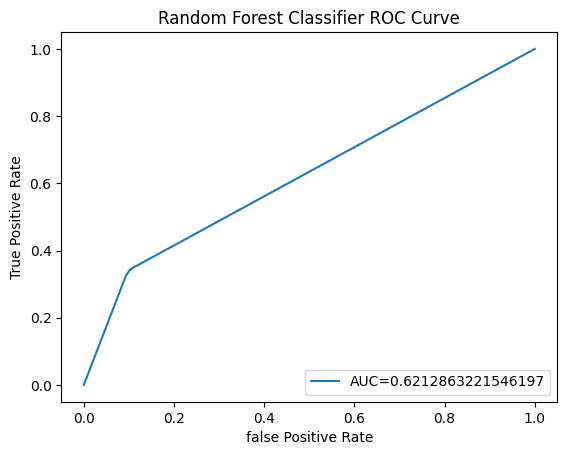

In [15]:
y_pred_proba= dtcmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Random Forest Classifier ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [16]:
print('Naive Bayes:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_nb))
print('Recall: ',metrics.recall_score(y_test, y_pred_nb, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_nb, zero_division=1))
print('CL Report: ',metrics.classification_report(y_test, y_pred_nb, zero_division=1))
accuracy_nb=metrics.accuracy_score(y_test, y_pred_nb)
accuracy_nb

Naive Bayes:
Accuracy:  0.8776402039329935
Recall:  0.36363636363636365
Precision:  0.45152722443559096
CL Report:                precision    recall  f1-score   support

           0       0.92      0.94      0.93      7303
           1       0.45      0.36      0.40       935

    accuracy                           0.88      8238
   macro avg       0.69      0.65      0.67      8238
weighted avg       0.87      0.88      0.87      8238



0.8776402039329935

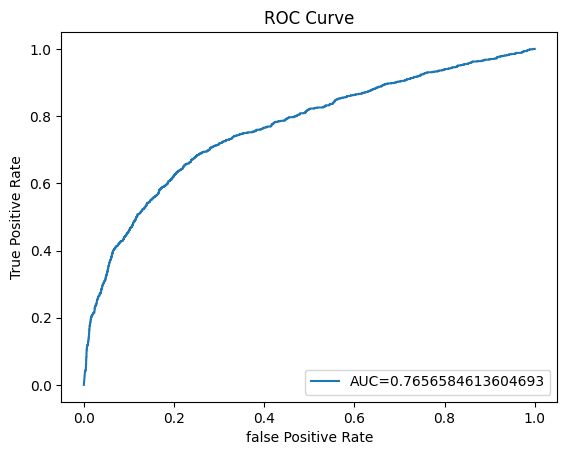

In [17]:
y_pred_proba= nbmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

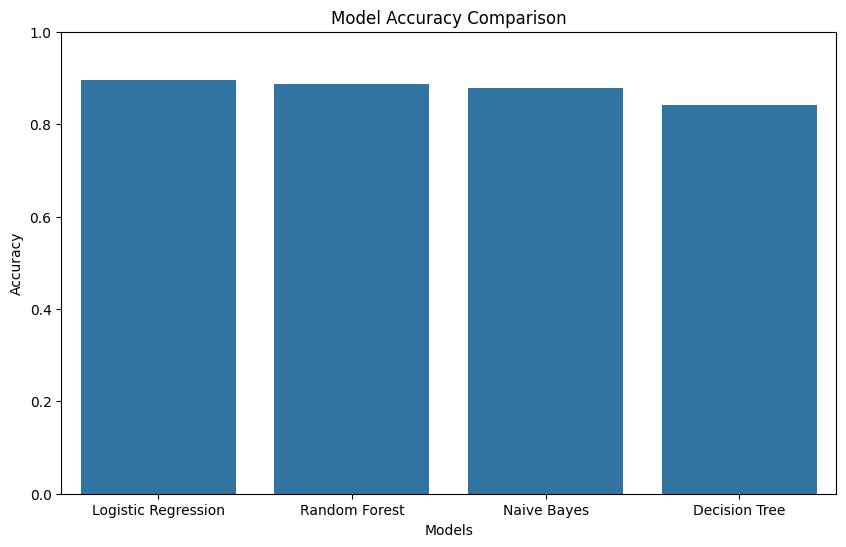

In [22]:
#visualise the results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree'], 
            y=[accuracy_log, accuracy_rfc, accuracy_nb, accuracy_dtc])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-
plt.show()

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-lear

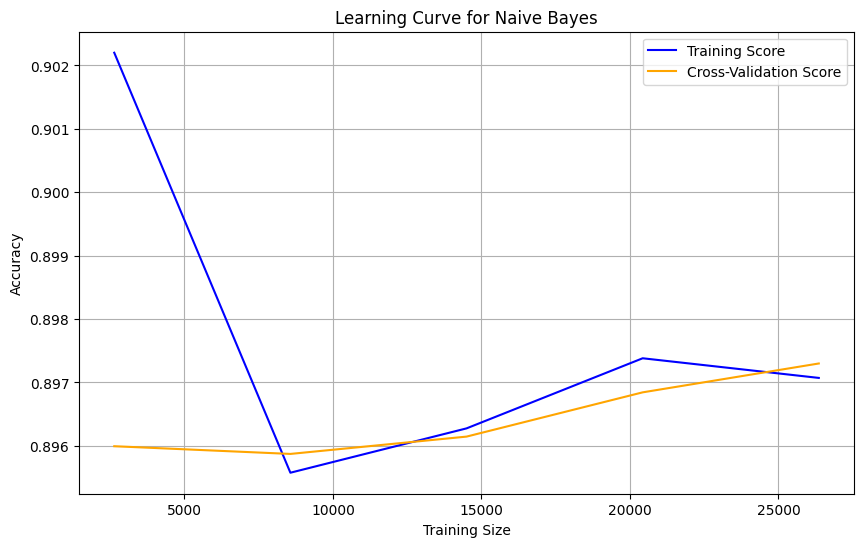

In [ ]:
#learning curve for logistic regression
train_sizes, train_scores, test_scores = learning_curve(logregmodel, x_train, y_train
, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange')

plt.title('Learning Curve for Logistical Regression')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()